In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [93]:
def next_day(date):
    """
    This function returns a list containing all the calendar dates, written in the form
    (yyyy,mm,dd), between 2 dates.

    Parameters
    ----------
    date: tuple of int
        A tuple that represents a date written in the form (yyyy,mm,dd).

    Yields
    ------
    date: tuple of int
        A tuple written in the form (yyyy,mm,dd) that rapresent the next calendar day
        of the input date.
    """
    months_30_days = [4,6,9,11]
    months_31_days = [1,3,5,7,8,10,12]
    #check if 28 february on bisextile year
    if date[2] == 28 and date[1] == 2 and date[0]%4 == 0:
        print(date[1])
        date = (date[0],2,29)
    # check if 29 february and if not bisextile year return an error message
    elif date[2] == 29 and date[1] == 2 and date[0]%4 == 0:
        date = (date[0],3,1)
    elif date[2] == 29 and date[1] == 2 and date[0]%4 != 0:
        print("{} is not a valid date".format(date))
        date = 0
    #check if 28 february
    elif date[2] == 28 and date[1] == 2:
        date = (date[0],3,1)
    #check if 31 december
    elif date[2] == 31 and date[1] == 12:
        date = (date[0]+1,1,1)
    #check if end of month
    elif date[2] == 30 and date[1] in months_30_days:
        date = (date[0],date[1]+1,1)
    elif date[2] == 31 and date[1] in months_31_days:
        date = (date[0],date[1]+1,1)
    # in every other case
    elif date[1] < 13 and date[2] < 32:
        date =  (date[0],date[1],date[2]+1)
    # return an error message if there is an invalid date as input
    else:
        print("{} is not a valid date".format(date))
        date = 0
    return date


def create_list_days(start,stop):
    """
    This function returns a list containing all the calendar days, written in the form
    (yyyy,mm,dd), between 2 dates.

    Parameters
    ----------
    start: tuple of int
        Starting date written in the form (yyyy,mm,dd).
    stop: tuple of int
        Last date written in the form (yyyy,mm,dd).

    Yields
    ------
    lst: list of tuples
        A list containg all the days between start and stop (both are included)
    """
    lst = []
    date = start
    while date != stop:
        lst.append(date)
        date = next_day(date)
    lst.append(date)
    return lst

In [237]:
def func(x,C,b,u):
    num = C*np.e**((b-u)*x)
    den = 1+num
    return (1-u/b)*num/den

In [94]:
START = (2021,1,1)
FINISH = (2021,3,1)
days = create_list_days(START,FINISH)
dates = [f"{day[2]}/{day[1]}/{day[0]}" for day in days]

## Reddit, stock prices and memes

On January 2021 the price for Gamestop stoks reached an all time high of 440$. This happened after the members of the reddit  community r/wallstreetbets, started buying a large quantity of the title, causing a chain reaction that led to the high price. <br> 
Once the price rose, the news starded spreading through the social network and new memes and discussions arise from all over the platform. <br> 
I tried to model the spreading of those posts using a simple SIS model. <br>
To retrieve the data I used pushift, a reddit archive, and I found all post created between 01/01/2021 and 03/01/2021 containing the words GME or gamestop in the title. After that I saved those posts of those to an infection database. <br> 
Once a subreddit contains a post about GME I considered it infected. After 15 days from the last post I considered it suscetible. The results are shown in the figure below

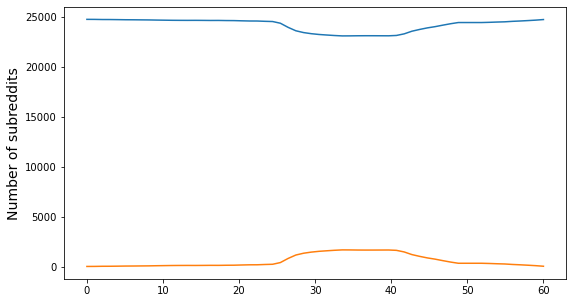

In [440]:
#load data
data = pd.read_csv("../scraping data/data/SIS_GME_final.csv",index_col=0)

#plot the number of suscetible and infected for each day
suscetible = np.zeros(61)
infected = np.zeros(61)
for i,column in enumerate(data):
    suscetible[i] = data[column].to_list().count("suscetible")
    infected[i] = data[column].to_list().count("infected")

infected = infected[1:]
suscetible = suscetible[1:]
xx=np.linspace(0,60,60)
plt.figure(figsize=(9,5))
plt.plot(xx,suscetible,label="Suscetible")
plt.plot(xx,infected,label="Infected")
plt.xlabel("")
plt.ylabel("Number of subreddits",fontsize=14)
#plt.xticks(xx, dates,rotation=60)
plt.show()

As we can the majority of our graph was not infected. This may be due to the fact that there is a very low chanche of infection for subreddits that are not interested in finance or memes (ex. r/ferrari).
Let's see if this change if we consider only subreddits that are in the same cluster as r/wallstreetbets.

In [152]:
from cdlib import algorithms, readwrite
#load clusters
louv_coms = readwrite.read_community_csv("../scraping data/data/louv_coms.csv", ",", str)
clusters=louv_coms.communities 

#save cluster containing r/wallstreetbets
for cluster in clusters:
    if "wallstreetbets" in cluster:
        wsb_cluster = cluster

In [223]:
new_df = data.iloc[[0],:]
#create a new infected database containing only the subreddit in the cluster of wallstreetbets
for subreddit in wsb_cluster:
    if data[data["subreddit"] == subreddit].index.to_list() != []:
        i = data[data["subreddit"] == subreddit].index.to_list()[0]
        new_df=pd.concat([new_df,data.iloc[[i],:]])
        
new_df.drop(0,inplace=True)



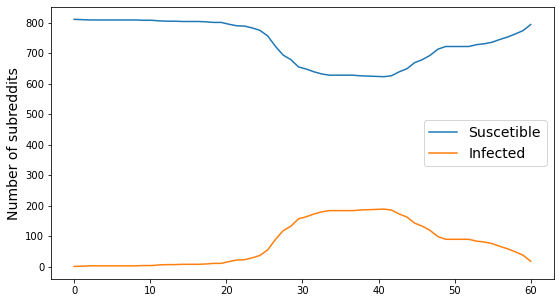

In [442]:
#plot the number of suscetible and infected for each day
suscetible = np.zeros(61)
infected = np.zeros(61)
for i,column in enumerate(data):
    suscetible[i] = new_df[column].to_list().count("suscetible")
    infected[i] = new_df[column].to_list().count("infected")

infected = infected[1:]
suscetible = suscetible[1:]
xx=np.linspace(0,60,60)
plt.figure(figsize=(9,5))
plt.plot(xx,suscetible,label="Suscetible")
plt.plot(xx,infected,label="Infected")
plt.xlabel("")
plt.ylabel("Number of subreddits",fontsize=14)
#plt.xticks(xx, dates,rotation=60)
plt.legend(fontsize=14)
plt.show()

The percentage of infected subreddits did not improve by much

## Relationship between infected and stock price

Let's see the relationship between the logarithm of the stock price and the number of infected subreddits.

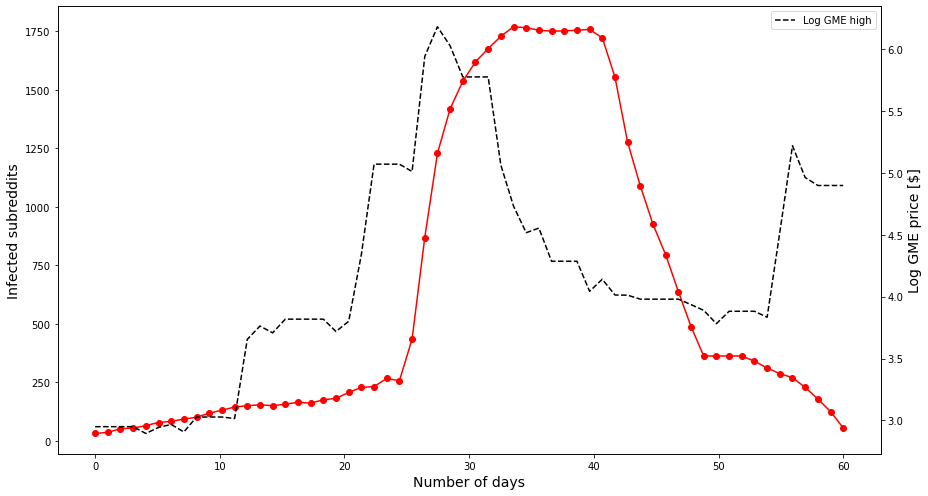

In [456]:
fig, ax1 = plt.subplots(figsize=(13,7))
ax1.errorbar(x=xx,y=new_inf,color="red",marker="o")
ax1.set_xlabel('Number of days',fontsize=14)
ax1.set_ylabel('Infected subreddits', fontsize=14)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Log GME price [$]',fontsize=14)  # we already handled the x-label with ax1
ax2.plot(xx,np.log(gme_stock),"--",label="Log GME high",color="black")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()

plt.show()

inserire discorso sul fatto che l'interesse non è legato al prezzo

## Spreading analysis

I used an SIS model to fit the data. In particular I used the function $$i(t)=(1-\frac{\mu}{\beta})\frac{Ce^{(\mu-\beta)t}}{1+Ce^{(\mu-\beta)t}} $$ from the graph os easy to see that there are 3 different regions: <br>
1. A linear phase from 01/01 to 25/01
2. An exponential increas from 25/01 to 09/02
3. An exponential decrease from 10/02 onwards <br> <br>
For each of those phases I computed $\beta,\mu,R_0$

In [357]:
err_inf = infected*.05
new_inf = infected + infected*.05
for i,value in enumerate(new_inf):
    if value < 250:
        err_inf[i]=infected[i]*.2
        new_inf[i]=infected[i] + infected[i]*.2

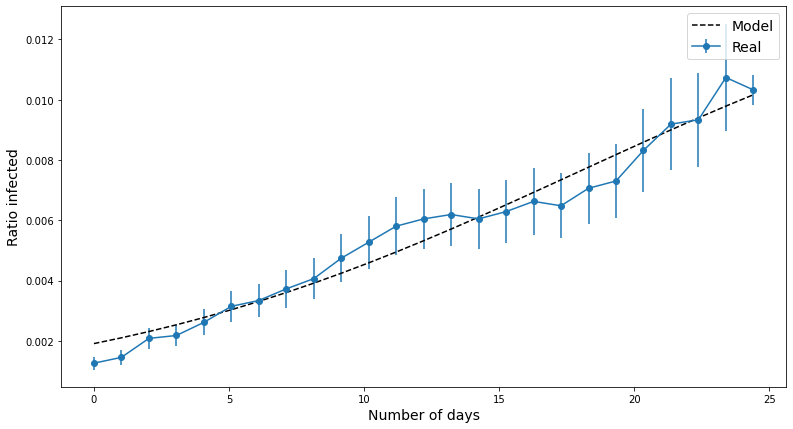

Adjusted X2=1.05
C=0.14+-0.02
b=7.1+-2.5
u=7.0+-2.5
R_0=1.02+- 0.51


In [455]:
y = new_inf[0:25]/data.shape[0]
d_y = err_inf[0:25]/data.shape[0]
x = xx[0:25]

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, x, y,p0=(0.3,0.5,0.2))
c_1 = popt[0]
b_1 = popt[1]
u_1 = popt[2]
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])
err_2 = np.sqrt(pcov[2][2])
err_R = np.sqrt((err_1/popt[2])**2+(popt[1]*err_2/popt[2]**2)**2)
chi_2 = (((y-func(x, *popt))/d_y)**2).sum()
nu = len(y)-3
adj_chi = chi_2/nu
plt.errorbar(x,y,yerr=d_y,marker="o",label="Real")
plt.plot(x, func(x, *popt),ls="--",color="black",label="Model")
plt.xlabel('Number of days',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.show()
print(f"Adjusted X2={adj_chi:.2f}")
print(f"C={popt[0]:.2f}+-{err_0:.2f}")
print(f"b={popt[1]:.1f}+-{err_1:.1f}")
print(f"u={popt[2]:.1f}+-{err_2:.1f}")
print(f"R_0={(popt[1]/popt[2]):.2f}+- {err_R:.2f}")

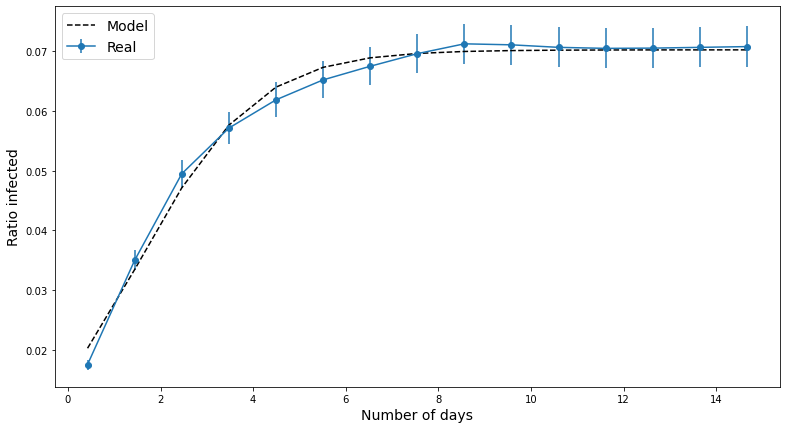

Adjusted X2=1.17
C=0.29+-0.03
b=11.3+-0.7
u=10.5+-0.7
R_0=1.08+- 0.10


In [454]:
y = new_inf[25:40]/data.shape[0]
d_y = err_inf[25:40]/data.shape[0]
x = xx[25:40]-25

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, x, y,p0=(0.3,0.5,0.2))
c_2 = popt[0]
b_2 = popt[1]
u_2 = popt[2]
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])
err_2 = np.sqrt(pcov[2][2])
err_R = np.sqrt((err_1/popt[2])**2+(popt[1]*err_2/popt[2]**2)**2)
chi_2 = (((y-func(x, *popt))/d_y)**2).sum()
nu = len(y)-3
adj_chi = chi_2/nu
plt.errorbar(x,y,yerr=d_y,marker="o",label="Real")
plt.plot(x, func(x, *popt),ls="--",color="black",label="Model")
plt.xlabel('Number of days',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.show()
print(f"Adjusted X2={adj_chi:.2f}")
print(f"C={popt[0]:.2f}+-{err_0:.2f}")
print(f"b={popt[1]:.1f}+-{err_1:.1f}")
print(f"u={popt[2]:.1f}+-{err_2:.1f}")
print(f"R_0={(popt[1]/popt[2]):.2f}+- {err_R:.2f}")

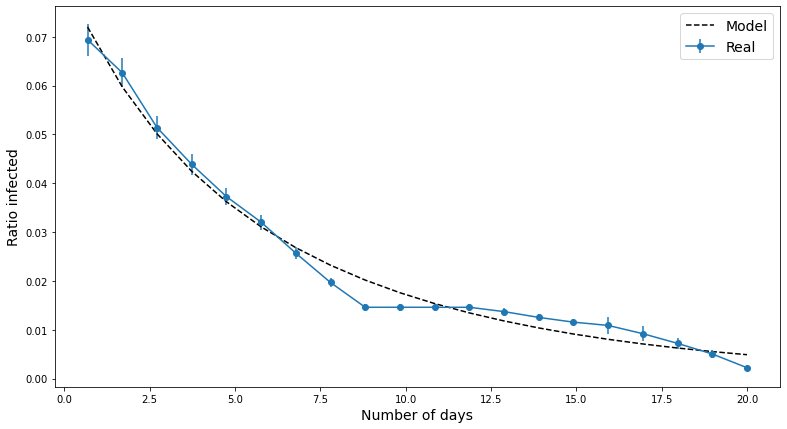

Adjusted X2=11.92
C=-0.42+-0.18
b=1.0+-0.5
u=1.1+-0.5
R_0=0.90+- 0.63


In [453]:
y = new_inf[40:]/data.shape[0]
d_y = err_inf[40:]/data.shape[0]
x = xx[40:]-40

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, x, y,p0=(0.3,0.5,0.2))
c_3 = popt[0]
b_3 = popt[1]
u_3 = popt[2]
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])
err_2 = np.sqrt(pcov[2][2])
err_R = np.sqrt((err_1/popt[2])**2+(popt[1]*err_2/popt[2]**2)**2)
chi_2 = (((y-func(x, *popt))/d_y)**2).sum()
nu = len(y)-3
adj_chi = chi_2/nu
plt.errorbar(x,y,yerr=d_y,marker="o",label="Real")
plt.plot(x, func(x, *popt),ls="--",color="black",label="Model")
plt.xlabel('Number of days',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.show()
print(f"Adjusted X2={adj_chi:.2f}")
print(f"C={popt[0]:.2f}+-{err_0:.2f}")
print(f"b={popt[1]:.1f}+-{err_1:.1f}")
print(f"u={popt[2]:.1f}+-{err_2:.1f}")
print(f"R_0={(popt[1]/popt[2]):.2f}+- {err_R:.2f}")

The first two model fit the data quite well, infact we have a value of $\frac{\chi^2}{\nu}\approx 1$, while the last model does not yield good results. <br>
Now let's put all togheter

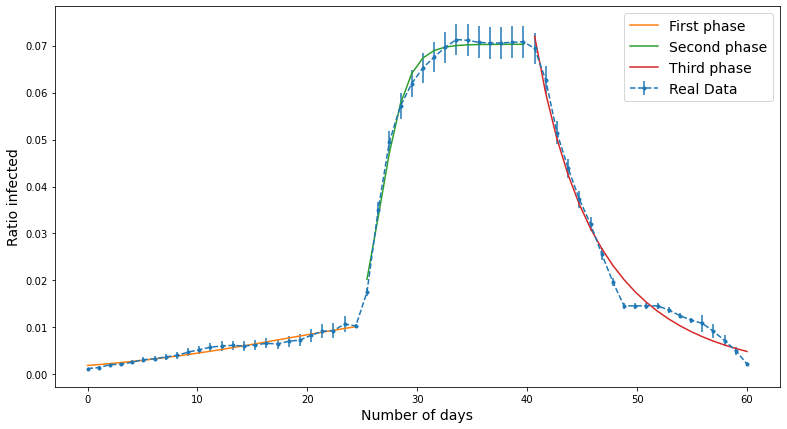

In [457]:
y = new_inf/data.shape[0]
d_y = err_inf/data.shape[0]

plt.figure(figsize=(13,7))
#compute best parameter to approximate real distribution

plt.errorbar(xx,y,yerr=d_y,marker=".",label="Real Data",linestyle="--")
plt.plot(xx[0:25], func(xx[0:25], c_1,b_1,u_1),label="First phase")
plt.plot(xx[25:40], func(xx[25:40]-25, c_2,b_2,u_2),label="Second phase")
plt.plot(xx[40:], func(xx[40:]-40, c_3,b_3,u_3),label="Third phase")

plt.xlabel('Number of days',fontsize=14)
plt.ylabel('Ratio infected', fontsize=14)
plt.legend(fontsize=14)
plt.show()